# <font color='orange'> Homework 3</font>

------
### Information
**Name:** Ahmed Ibrahim

**Student Number:** 261032796

**Date:** 2022-02-08

**Course Number:** YCBS 258 - Practical Machine Learning

------

Build the AlexNet architecture and train it on the CIFAR10 dataset.

You may resize some of the kernel sizes (mainly the first one) and the number of kernels because CIFAR100 is a smaller dataset than ImageNet, as well as lower-resolution (32x32 vs 224x224).

You may resize the number of kernels used per layer if it speeds up training and/or preserves accuracy. The exact AlexNet architecture and number of units will not work.

Report training, validation and test errors. Which hyperparameters did you change to improve performance?

**MAKE SURE YOU USE A GPU!** Top menu select 'Runtime', then 'Runtime Type'. Make sure 'Hardware Accelerator' has the option 'GPU' selected.

Tips:
- Start with only a few of a layers and check if the network can learn.
- Add units and layers progressively.
- Kernels that are too large or too much pooling will reduce the size of layer ouputs
- Try Batch Norm and Dropout
- If you don't reproduce the exact architecture, that is fine. Explain what you changed and why!.
- Functional API!


## Starter Code

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import datasets
import matplotlib.pyplot as plt

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

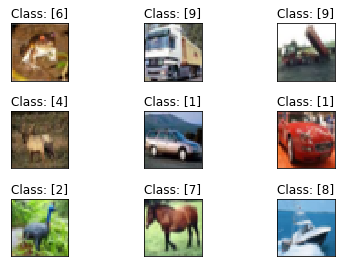

In [ ]:
fig = plt.figure()

for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.tight_layout()
  plt.imshow(X_train_full[i], interpolation='none')
  plt.title('Class: {}'.format(y_train_full[i]))
  plt.xticks([])
  plt.yticks([])

In [ ]:
X_train_full.shape

(50000, 32, 32, 3)

## Data Mining

### Setup Environnment

In [ ]:
# Check if running in colab.
import sys
print ('Running in colab:', 'google.colab' in sys.modules)

Running in colab: True


In [ ]:
# Check connection to a GPU.
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Feb  8 21:18:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Check RAM runtime.
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Check CPU specs.
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Core(s) per socket:  2
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0-3
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [ ]:
# Colors.
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### Import libraries, modules and dataset

In [ ]:
import random
random.seed(12)
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

In [ ]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras.utils import to_categorical
from keras import regularizers

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Load data.
from keras.datasets import cifar10
cifar_10_data = cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


## Data Exploration

In [ ]:
# Seperate data according to train/test and labels/predictors.
(X_train, y_train), (X_test, y_test) = cifar_10_data

In [ ]:
# List of classes.
list_of_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
# Check data shape.
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (50000, 32, 32, 3)
y_train: (50000, 1)
X_test: (10000, 32, 32, 3)
y_test: (10000, 1)


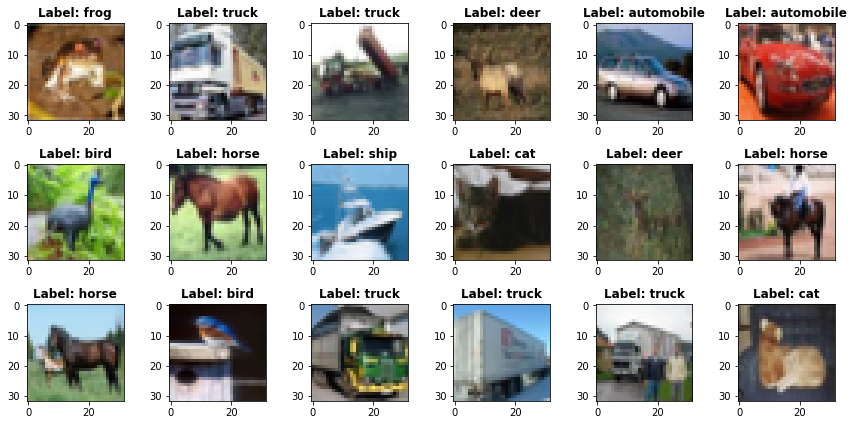

In [ ]:
# Visualize sample of images.
number_row = 3
number_col = 6
product = number_row*number_col
images = X_train[:product]
labels = y_train[:product]
fig, axes = plt.subplots(number_row, number_col, figsize=(2*number_col, 2*number_row))

for i in range(product):
    ax = axes[i//number_col, i%number_col]
    ax.imshow(images[i])
    ax.set_title('Label: {}'.format(list_of_classes[int(labels[i])]), fontweight = 'bold')
    
plt.tight_layout()
plt.show();

In [ ]:
# Check frequency of every class in dataset for training set. 
np.unique(y_train, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [ ]:
# Check frequency of every class in dataset for testing set. 
np.unique(y_test, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

## Data Cleaning

In [ ]:
# Shuffle data.
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 10000, random_state = 12)
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (50000, 32, 32, 3)
y_train: (50000, 1)
X_test: (10000, 32, 32, 3)
y_test: (10000, 1)


In [ ]:
# One-hot Encode the labels.
y_train_c = to_categorical(y_train)
y_test_c = to_categorical(y_test)
print(f'y_train: {y_train_c.shape}')
print(f'y_test: {y_test_c.shape}')

y_train: (50000, 10)
y_test: (10000, 10)


In [ ]:
# Normalize pixels.
X_train_c = X_train.astype('float32')/255.0
X_test_c = X_test.astype('float32')/255.0
print(f'X_train: {X_train_c.shape}')
print(f'X_test: {X_test_c.shape}')

X_train: (50000, 32, 32, 3)
X_test: (10000, 32, 32, 3)


## Predictive Modeling

### Model 1

The initial model contains a neural topology based on the AlexNet CNN architecture adapted for the CIFAR10. The notable changes include:
*   The kernel size for the covolution layers have been reduced to either 5 x 5 or 3 x 3 since the images are only 32 x 32 pixels as opposed to the larger images used in the ImageNet dataset.
*   Also smaller strides for convolution and pooling are uses being (2,2) and (1,1).
*   The 'Adam' optimizer with a small learning rate has been added since it lead to greater accuracy than the 'SGD' optimizer.
*   The batch size and epochs are set to 25 as this combination lead to a good balance on runtime and accuracy for the sake of searching for good hyperparameters.

In [ ]:
# Function to run initial AlexNet model
def alexnet_initial_template(train_x, train_y, test_x, test_y):
    K.clear_session()
    inputs = keras.Input(shape = (32, 32, 3), name = 'Input_CIFAR_10')
    x = layers.Conv2D(filters = 96, input_shape = (32, 32, 3), kernel_size = (5, 5), strides = (2, 2), padding = 'valid', name = 'Conv_1')(inputs)
    x = layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same', name = 'MaxPool_1')(x)
    x = layers.Conv2D(filters = 256, input_shape = (32, 32, 3), kernel_size = (5, 5), strides = (2, 2), padding = 'same', name = 'Conv_2')(x)
    x = layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same', name = 'MaxPool_2')(x)
    x = layers.Conv2D(filters = 384, input_shape = (32, 32, 3), kernel_size = (3, 3), strides = (1, 1), padding = 'same', name = 'Conv_3')(x)
    x = layers.Conv2D(filters = 384, input_shape = (32, 32, 3), kernel_size = (3, 3), strides = (1, 1), padding = 'same', name = 'Conv_4')(x)
    x = layers.Conv2D(filters = 256, input_shape = (32, 32, 3), kernel_size = (3, 3), strides = (1, 1), padding = 'same', name = 'Conv_5')(x)
    x = layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same', name = 'MaxPool_3')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation = 'relu')(x)
    x = layers.Dense(4096, activation = 'relu')(x)
    x = layers.Dense(1000, activation = 'relu')(x)
    outputs = layers.Dense(10, activation = 'softmax')(x)
    model = keras.Model(inputs = inputs, outputs = outputs, name = 'CIFAR_10_AlexNet_Model')
    model.summary()
    model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adam(learning_rate = 0.00005), metrics = ['accuracy'])
    history = model.fit(train_x, train_y, batch_size = 25, epochs = 25, validation_split = 0.25)
    test_scores = model.evaluate(test_x, test_y, verbose = 2)
    return history, test_scores

In [ ]:
# Function to plot accuracy and validation accuracy vs epochs
def plot_experiment(title, experiment):
    plt.style.use('fivethirtyeight')
    plt.title(title, y = 1.1)
    plt.xlabel('epochs')
    plt.plot(experiment[0].history['accuracy'], label = 'accuracy')
    plt.plot(experiment[0].history['val_accuracy'], label = 'val_accuracy')
    plt.legend(loc = 'lower right')
    plt.show();

In [ ]:
# Function to print test accuracy
def print_test_error(experiment):
    print("Test accuracy: {:.2%}".format(experiment[1][1]))

In [ ]:
# Run intial experiment
initial_experiment = alexnet_initial_template(X_train_c, y_train_c, X_test_c, y_test_c)

Model: "CIFAR_10_AlexNet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_CIFAR_10 (InputLayer)  [(None, 32, 32, 3)]      0         
                                                                 
 Conv_1 (Conv2D)             (None, 14, 14, 96)        7296      
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 7, 7, 96)          0         
                                                                 
 Conv_2 (Conv2D)             (None, 4, 4, 256)         614656    
                                                                 
 MaxPool_2 (MaxPooling2D)    (None, 2, 2, 256)         0         
                                                                 
 Conv_3 (Conv2D)             (None, 2, 2, 384)         885120    
                                                                 
 Conv_4 (Conv2D)             (None, 2, 2, 38

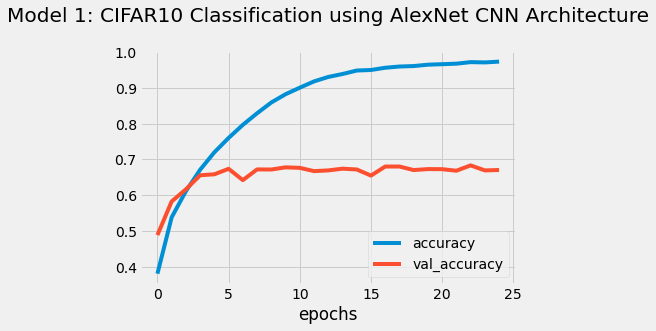

In [ ]:
# Plot experiment
plot_experiment("Model 1: CIFAR10 Classification using AlexNet CNN Architecture", initial_experiment)

In [ ]:
# Print test error for initial experiment
print_test_error(initial_experiment)

Test accuracy: 67.85%


## Model Optimization

### Model 2

For the second model, the following changes are added:
* Batch normmalization layers have been added after convolution layer. Many AlexNet CNN architectures used batch normalization after each convolution layer. Thus, I added it as well and it seems higher accuracies are achieved with fewer epochs as a result.
* A dropout layer is added after every dense layer. This was added in the hopes of dropping ineffective neurons. Very little change in performance was seen with a dropout rate of 0.3 for the dense layers. Thus, the dropout rate was increased from 0.3 to 0.4.
* The strides for the convolution layers have been reduced to (1,1) and their kernel sizes for the convolution layers have been kept to 3 x 3. This smaller filters lead to higher accuracies but also higher runtime.

In [ ]:
# Function to run second AlexNet model
def alexnet_second_template(train_x, train_y, test_x, test_y):
    K.clear_session()
    inputs = keras.Input(shape = (32, 32, 3), name = 'Input_CIFAR_10')
    x = layers.Conv2D(filters = 96, input_shape = (32, 32, 3), kernel_size = (3, 3), strides = (1, 1), padding = 'valid', name = 'Conv_1')(inputs)
    X = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same', name = 'MaxPool_1')(x)
    x = layers.Conv2D(filters = 256, input_shape = (32, 32, 3), kernel_size = (3, 3), strides = (1, 1), padding = 'same', name = 'Conv_2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same', name = 'MaxPool_2')(x)
    x = layers.Conv2D(filters = 384, input_shape = (32, 32, 3), kernel_size = (3, 3), strides = (1, 1), padding = 'same', name = 'Conv_3')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters = 384, input_shape = (32, 32, 3), kernel_size = (3, 3), strides = (1, 1), padding = 'same', name = 'Conv_4')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters = 256, input_shape = (32, 32, 3), kernel_size = (3, 3), strides = (1, 1), padding = 'same', name = 'Conv_5')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same', name = 'MaxPool_3')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation = 'relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(4096, activation = 'relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1000, activation = 'relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(10, activation = 'softmax')(x)
    model = keras.Model(inputs = inputs, outputs = outputs, name = 'CIFAR_10_AlexNet_Model')
    model.compile(loss = keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate = 0.00005), metrics = ['accuracy'])
    history = model.fit(train_x, train_y, batch_size = 25, epochs = 25, validation_split = 0.25)
    test_scores = model.evaluate(test_x, test_y, verbose = 2)
    model.summary()
    return history, test_scores

In [ ]:
# Run the second experiment
second_experiment = alexnet_second_template(X_train_c, y_train_c, X_test_c, y_test_c)

Epoch 1/25
1500/1500 [==============================] - 20s 12ms/step - loss: 1.6613 - accuracy: 0.4079 - val_loss: 1.4627 - val_accuracy: 0.4959
Epoch 2/25
1500/1500 [==============================] - 18s 12ms/step - loss: 1.2054 - accuracy: 0.5702 - val_loss: 1.0281 - val_accuracy: 0.6307
Epoch 3/25
1500/1500 [==============================] - 18s 12ms/step - loss: 1.0136 - accuracy: 0.6459 - val_loss: 0.9693 - val_accuracy: 0.6473
Epoch 4/25
1500/1500 [==============================] - 18s 12ms/step - loss: 0.8938 - accuracy: 0.6875 - val_loss: 0.8718 - val_accuracy: 0.6906
Epoch 5/25
1500/1500 [==============================] - 18s 12ms/step - loss: 0.7983 - accuracy: 0.7237 - val_loss: 0.7752 - val_accuracy: 0.7304
Epoch 6/25
1500/1500 [==============================] - 18s 12ms/step - loss: 0.7267 - accuracy: 0.7476 - val_loss: 0.8123 - val_accuracy: 0.7194
Epoch 7/25
1500/1500 [==============================] - 18s 12ms/step - loss: 0.6541 - accuracy: 0.7759 - val_loss: 0.7083 -

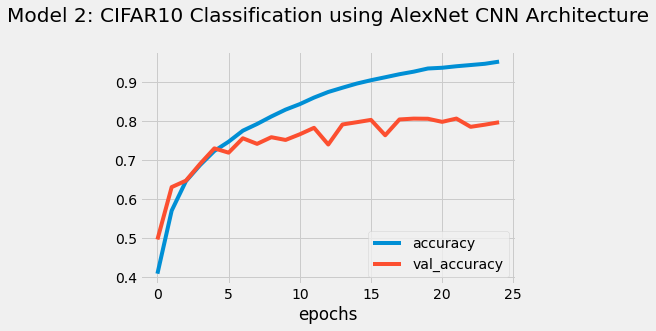

In [ ]:
# Plot the second experiment
plot_experiment("Model 2: CIFAR10 Classification using AlexNet CNN Architecture", second_experiment)

In [ ]:
# Print test error for second experiment
print_test_error(second_experiment)

Test accuracy: 80.17%


### Model 3

For the third model, the following changes are added:
- For all dense layers, the 'Glorot Normal' kernel initializer has been applied. This did not lead to any significant increase in the final accuracy but higher accuracies were achieved with fewer epochs throughout the training process. 

In [ ]:
# Function to run third AlexNet model
def alexnet_third_template(train_x, train_y, test_x, test_y):
    K.clear_session()
    inputs = keras.Input(shape = (32, 32, 3), name = 'Input_CIFAR_10')
    x = layers.Conv2D(filters = 96, input_shape = (32, 32, 3), kernel_size = (3, 3), strides = (1, 1), padding = 'valid', name = 'Conv_1')(inputs)
    X = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same', name = 'MaxPool_1')(x)
    x = layers.Conv2D(filters = 256, input_shape = (32, 32, 3), kernel_size = (3, 3), strides = (1, 1), padding = 'same', name = 'Conv_2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same', name = 'MaxPool_2')(x)
    x = layers.Conv2D(filters = 384, input_shape = (32, 32, 3), kernel_size = (3, 3), strides = (1, 1), padding = 'same', name = 'Conv_3')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters = 384, input_shape = (32, 32, 3), kernel_size = (3, 3), strides = (1, 1), padding = 'same', name = 'Conv_4')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters = 256, input_shape = (32, 32, 3), kernel_size = (3, 3), strides = (1, 1), padding = 'same', name = 'Conv_5')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same', name = 'MaxPool_3')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation = 'relu', kernel_initializer = initializers.GlorotNormal())(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(4096, activation = 'relu', kernel_initializer = initializers.GlorotNormal())(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1000, activation = 'relu', kernel_initializer = initializers.GlorotNormal())(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(10, activation = 'softmax')(x)
    model = keras.Model(inputs = inputs, outputs = outputs, name = 'CIFAR_10_AlexNet_Model')
    model.compile(loss = keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate = 0.00005), metrics = ['accuracy'])
    history = model.fit(train_x, train_y, batch_size = 25, epochs = 25, validation_split = 0.25)
    test_scores = model.evaluate(test_x, test_y, verbose = 2)
    model.summary()
    return history, test_scores

In [ ]:
# Run the third experiment
third_experiment = alexnet_third_template(X_train_c, y_train_c, X_test_c, y_test_c)

Epoch 1/25
1500/1500 [==============================] - 19s 12ms/step - loss: 1.6675 - accuracy: 0.4080 - val_loss: 1.3118 - val_accuracy: 0.5243
Epoch 2/25
1500/1500 [==============================] - 18s 12ms/step - loss: 1.2136 - accuracy: 0.5694 - val_loss: 1.1057 - val_accuracy: 0.6022
Epoch 3/25
1500/1500 [==============================] - 18s 12ms/step - loss: 1.0189 - accuracy: 0.6422 - val_loss: 0.9149 - val_accuracy: 0.6823
Epoch 4/25
1500/1500 [==============================] - 18s 12ms/step - loss: 0.8961 - accuracy: 0.6897 - val_loss: 0.8039 - val_accuracy: 0.7278
Epoch 5/25
1500/1500 [==============================] - 18s 12ms/step - loss: 0.7900 - accuracy: 0.7271 - val_loss: 0.9017 - val_accuracy: 0.6941
Epoch 6/25
1500/1500 [==============================] - 18s 12ms/step - loss: 0.7167 - accuracy: 0.7523 - val_loss: 0.7423 - val_accuracy: 0.7410
Epoch 7/25
1500/1500 [==============================] - 18s 12ms/step - loss: 0.6483 - accuracy: 0.7749 - val_loss: 0.8617 -

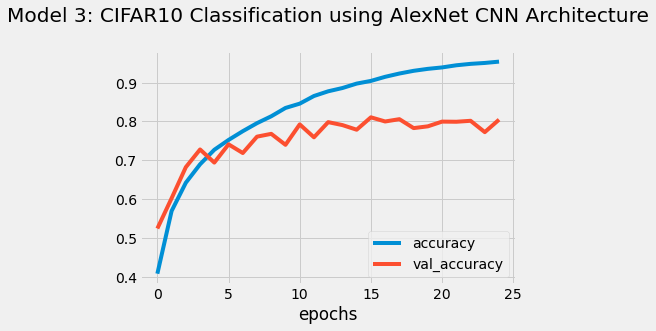

In [ ]:
# Plot the third experiment
plot_experiment("Model 3: CIFAR10 Classification using AlexNet CNN Architecture", third_experiment)

In [ ]:
# Print test error for third experiment
print_test_error(third_experiment)

Test accuracy: 80.63%


### Model 4

For the fourth model, the following changes have been applied:
* A dropout layer is added after each max pooling layer.
* The 'elu' activation layer is added to the third to fifth convolution layer.
The following model incorporated an activation function calculation and dropout layer after convolutional layer. The activation function was added to see if adding non-linearity between convolution layers would lead to a greater performance. The addition of more dropout layers was done in the hopes of seeing better performance as adding dropout layers after the dense layers was effective. 

In [ ]:
# Function to run fourth AlexNet model
def alexnet_fourth_template(train_x, train_y, test_x, test_y):
    K.clear_session()
    inputs = keras.Input(shape = (32, 32, 3), name = 'Input_CIFAR_10')
    x = layers.Conv2D(filters = 96, input_shape = (32, 32, 3), kernel_size = (3, 3), strides = (1, 1), padding = 'valid', name = 'Conv_1')(inputs)
    X = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same', name = 'MaxPool_1')(x)
    x = layers.Conv2D(filters = 256, input_shape = (32, 32, 3), kernel_size = (3, 3), strides = (1, 1), padding = 'same', name = 'Conv_2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same', name = 'MaxPool_2')(x)
    x = layers.Conv2D(filters = 384, input_shape = (32, 32, 3), activation = 'elu', kernel_size = (3, 3), strides = (1, 1), padding = 'same', name = 'Conv_3')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters = 384, input_shape = (32, 32, 3), activation = 'elu', kernel_size = (3, 3), strides = (1, 1), padding = 'same', name = 'Conv_4')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters = 256, input_shape = (32, 32, 3), activation = 'elu', kernel_size = (3, 3), strides = (1, 1), padding = 'same', name = 'Conv_5')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same', name = 'MaxPool_3')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation = 'relu', kernel_initializer = initializers.GlorotNormal())(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(4096, activation = 'relu', kernel_initializer = initializers.GlorotNormal())(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1000, activation = 'relu', kernel_initializer = initializers.GlorotNormal())(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(10, activation = 'softmax')(x)
    model = keras.Model(inputs = inputs, outputs = outputs, name = 'CIFAR_10_AlexNet_Model')
    model.compile(loss = keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate = 0.00005), metrics = ['accuracy'])
    history = model.fit(train_x, train_y, batch_size = 25, epochs = 25, validation_split = 0.25)
    test_scores = model.evaluate(test_x, test_y, verbose = 2)
    model.summary()
    return history, test_scores

In [ ]:
# Run the fourth experiment
fourth_experiment = alexnet_fourth_template(X_train_c, y_train_c, X_test_c, y_test_c)

Epoch 1/25
1500/1500 [==============================] - 19s 12ms/step - loss: 1.7939 - accuracy: 0.3663 - val_loss: 1.4060 - val_accuracy: 0.4962
Epoch 2/25
1500/1500 [==============================] - 18s 12ms/step - loss: 1.2930 - accuracy: 0.5378 - val_loss: 1.1175 - val_accuracy: 0.6016
Epoch 3/25
1500/1500 [==============================] - 18s 12ms/step - loss: 1.0628 - accuracy: 0.6246 - val_loss: 1.0975 - val_accuracy: 0.6224
Epoch 4/25
1500/1500 [==============================] - 18s 12ms/step - loss: 0.9173 - accuracy: 0.6790 - val_loss: 0.9923 - val_accuracy: 0.6612
Epoch 5/25
1500/1500 [==============================] - 18s 12ms/step - loss: 0.8213 - accuracy: 0.7122 - val_loss: 1.1579 - val_accuracy: 0.6085
Epoch 6/25
1500/1500 [==============================] - 18s 12ms/step - loss: 0.7325 - accuracy: 0.7443 - val_loss: 0.6869 - val_accuracy: 0.7627
Epoch 7/25
1500/1500 [==============================] - 18s 12ms/step - loss: 0.6663 - accuracy: 0.7701 - val_loss: 0.7048 -

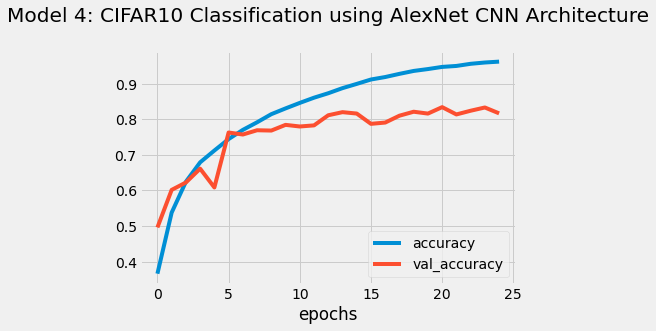

In [ ]:
# Plot fourth experiment
plot_experiment("Model 4: CIFAR10 Classification using AlexNet CNN Architecture", fourth_experiment)

In [ ]:
# Print test error for fourth experiment
print_test_error(fourth_experiment)

Test accuracy: 82.48%


### Model 5

For the fifth model, the following changes have been applied:
* The 'l2' kernel regularizer is added to each convolution layer.
The 'Ridge' regularizer was added to each convolution layer to add a penalty on the layer's kernel in the hopes so that it converges more smoothly to better performing weights. 


In [ ]:
# Function to run fifth AlexNet model
def alexnet_fifth_template(train_x, train_y, test_x, test_y):
    K.clear_session()
    inputs = keras.Input(shape = (32, 32, 3), name = 'Input_CIFAR_10')
    x = layers.Conv2D(filters = 96, input_shape = (32, 32, 3), kernel_size = (3, 3), strides = (1, 1), kernel_regularizer = regularizers.l2(1e-4), padding = 'valid', name = 'Conv_1')(inputs)
    X = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same', name = 'MaxPool_1')(x)
    x = layers.Conv2D(filters = 256, input_shape = (32, 32, 3), kernel_size = (3, 3), strides = (1, 1), kernel_regularizer = regularizers.l2(1e-4), padding = 'same', name = 'Conv_2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same', name = 'MaxPool_2')(x)
    x = layers.Conv2D(filters = 384, input_shape = (32, 32, 3), activation = 'elu', kernel_size = (3, 3), strides = (1, 1), kernel_regularizer = regularizers.l2(1e-4), padding = 'same', name = 'Conv_3')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters = 384, input_shape = (32, 32, 3), activation = 'elu', kernel_size = (3, 3), strides = (1, 1), kernel_regularizer = regularizers.l2(1e-4), padding = 'same', name = 'Conv_4')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters = 256, input_shape = (32, 32, 3), activation = 'elu', kernel_size = (3, 3), strides = (1, 1), kernel_regularizer = regularizers.l2(1e-4), padding = 'same', name = 'Conv_5')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same', name = 'MaxPool_3')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation = 'relu', kernel_initializer = initializers.GlorotNormal())(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(4096, activation = 'relu', kernel_initializer = initializers.GlorotNormal())(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1000, activation = 'relu', kernel_initializer = initializers.GlorotNormal())(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(10, activation = 'softmax')(x)
    model = keras.Model(inputs = inputs, outputs = outputs, name = 'CIFAR_10_AlexNet_Model')
    model.compile(loss = keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate = 0.00005), metrics = ['accuracy'])
    history = model.fit(train_x, train_y, batch_size = 25, epochs = 25, validation_split = 0.25)
    test_scores = model.evaluate(test_x, test_y, verbose = 2)
    model.summary()
    return history, test_scores

In [ ]:
# Run the fifth experiment
fifth_experiment = alexnet_fifth_template(X_train_c, y_train_c, X_test_c, y_test_c)

Epoch 1/25
1500/1500 [==============================] - 20s 13ms/step - loss: 1.8880 - accuracy: 0.3724 - val_loss: 1.4294 - val_accuracy: 0.5282
Epoch 2/25
1500/1500 [==============================] - 19s 13ms/step - loss: 1.3899 - accuracy: 0.5400 - val_loss: 1.7139 - val_accuracy: 0.4373
Epoch 3/25
1500/1500 [==============================] - 19s 13ms/step - loss: 1.1704 - accuracy: 0.6269 - val_loss: 1.2766 - val_accuracy: 0.5906
Epoch 4/25
1500/1500 [==============================] - 19s 13ms/step - loss: 1.0346 - accuracy: 0.6754 - val_loss: 1.1568 - val_accuracy: 0.6423
Epoch 5/25
1500/1500 [==============================] - 19s 13ms/step - loss: 0.9350 - accuracy: 0.7150 - val_loss: 0.8794 - val_accuracy: 0.7313
Epoch 6/25
1500/1500 [==============================] - 19s 13ms/step - loss: 0.8477 - accuracy: 0.7450 - val_loss: 0.8984 - val_accuracy: 0.7252
Epoch 7/25
1500/1500 [==============================] - 19s 13ms/step - loss: 0.7836 - accuracy: 0.7671 - val_loss: 0.8652 -

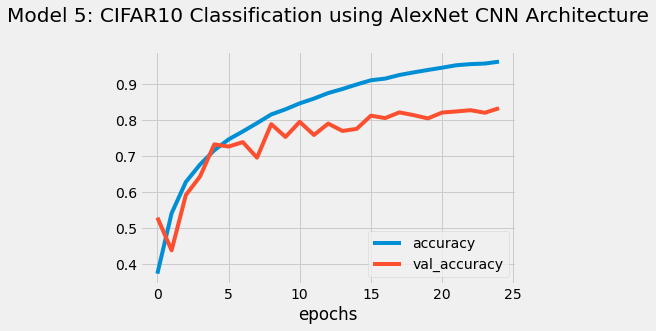

In [ ]:
# Plot fifth experiment
plot_experiment("Model 5: CIFAR10 Classification using AlexNet CNN Architecture", fifth_experiment)

In [ ]:
# Print test error for fourth experiment
print_test_error(fifth_experiment)

Test accuracy: 83.29%


### Final Model


For the final model, the following changes have been applied:
* The learning rate for 'Adam' optimizer is set to: 0.00003.
* The epochs and batch size are changed respectively to 100 and 20.
For the last model, the learning rate was reduced slighlty in the attempts of reducing unstability associated to the weight changes after each batch run. Lastly, more epochs and a smaller batch size were implemented to see the impact on the accuracy plots. 

In [ ]:
# Function to run final AlexNet model
def alexnet_final_template(train_x, train_y, test_x, test_y):
    K.clear_session()
    inputs = keras.Input(shape = (32, 32, 3), name = 'Input_CIFAR_10')
    x = layers.Conv2D(filters = 96, input_shape = (32, 32, 3), kernel_size = (3, 3), strides = (1, 1), kernel_regularizer = regularizers.l2(1e-4), padding = 'valid', name = 'Conv_1')(inputs)
    X = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same', name = 'MaxPool_1')(x)
    x = layers.Conv2D(filters = 256, input_shape = (32, 32, 3), kernel_size = (3, 3), strides = (1, 1), kernel_regularizer = regularizers.l2(1e-4), padding = 'same', name = 'Conv_2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same', name = 'MaxPool_2')(x)
    x = layers.Conv2D(filters = 384, input_shape = (32, 32, 3), activation = 'elu', kernel_size = (3, 3), strides = (1, 1), kernel_regularizer = regularizers.l2(1e-4), padding = 'same', name = 'Conv_3')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters = 384, input_shape = (32, 32, 3), activation = 'elu', kernel_size = (3, 3), strides = (1, 1), kernel_regularizer = regularizers.l2(1e-4), padding = 'same', name = 'Conv_4')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters = 256, input_shape = (32, 32, 3), activation = 'elu', kernel_size = (3, 3), strides = (1, 1), kernel_regularizer = regularizers.l2(1e-4), padding = 'same', name = 'Conv_5')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same', name = 'MaxPool_3')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation = 'relu', kernel_initializer = initializers.GlorotNormal())(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(4096, activation = 'relu', kernel_initializer = initializers.GlorotNormal())(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1000, activation = 'relu', kernel_initializer = initializers.GlorotNormal())(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(10, activation = 'softmax')(x)
    model = keras.Model(inputs = inputs, outputs = outputs, name = 'CIFAR_10_AlexNet_Model')
    model.compile(loss = keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate = 0.00003), metrics = ['accuracy'])
    history = model.fit(train_x, train_y, batch_size = 20, epochs = 100, validation_split = 0.25)
    test_scores = model.evaluate(test_x, test_y, verbose = 2)
    model.summary()
    return history, test_scores

In [ ]:
# Run the final experiment
final_experiment = alexnet_final_template(X_train_c, y_train_c, X_test_c, y_test_c)

Epoch 1/100
1875/1875 [==============================] - 24s 12ms/step - loss: 1.9685 - accuracy: 0.3508 - val_loss: 1.5160 - val_accuracy: 0.4799
Epoch 2/100
1875/1875 [==============================] - 22s 12ms/step - loss: 1.4859 - accuracy: 0.5055 - val_loss: 1.2622 - val_accuracy: 0.5831
Epoch 3/100
1875/1875 [==============================] - 22s 12ms/step - loss: 1.2527 - accuracy: 0.5937 - val_loss: 1.1755 - val_accuracy: 0.6151
Epoch 4/100
1875/1875 [==============================] - 23s 12ms/step - loss: 1.1196 - accuracy: 0.6430 - val_loss: 0.9881 - val_accuracy: 0.6948
Epoch 5/100
1875/1875 [==============================] - 23s 12ms/step - loss: 1.0152 - accuracy: 0.6831 - val_loss: 0.9961 - val_accuracy: 0.6931
Epoch 6/100
1875/1875 [==============================] - 23s 12ms/step - loss: 0.9215 - accuracy: 0.7177 - val_loss: 0.9154 - val_accuracy: 0.7244
Epoch 7/100
1875/1875 [==============================] - 22s 12ms/step - loss: 0.8584 - accuracy: 0.7403 - val_loss: 0

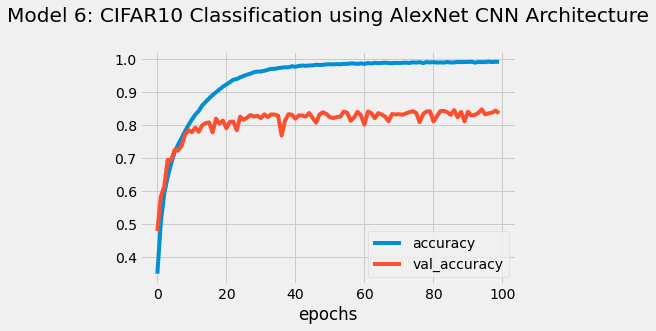

In [ ]:
# Plot final experiment
plot_experiment("Model 6: CIFAR10 Classification using AlexNet CNN Architecture", final_experiment)

In [ ]:
# Print test error for final experiment
print_test_error(final_experiment)

Test accuracy: 84.01%


## Conclusion

Overall, the final test accuracy obtaining for the 'final' CNN model in this assignment is 84.02 % and the validation accuracy being 83.48 %. A plot of the CNN topology used for the 'final' model can be found in the next cell. For future work, data augmentation will be implemented as well as exploring other combinations of hyperparameters. 

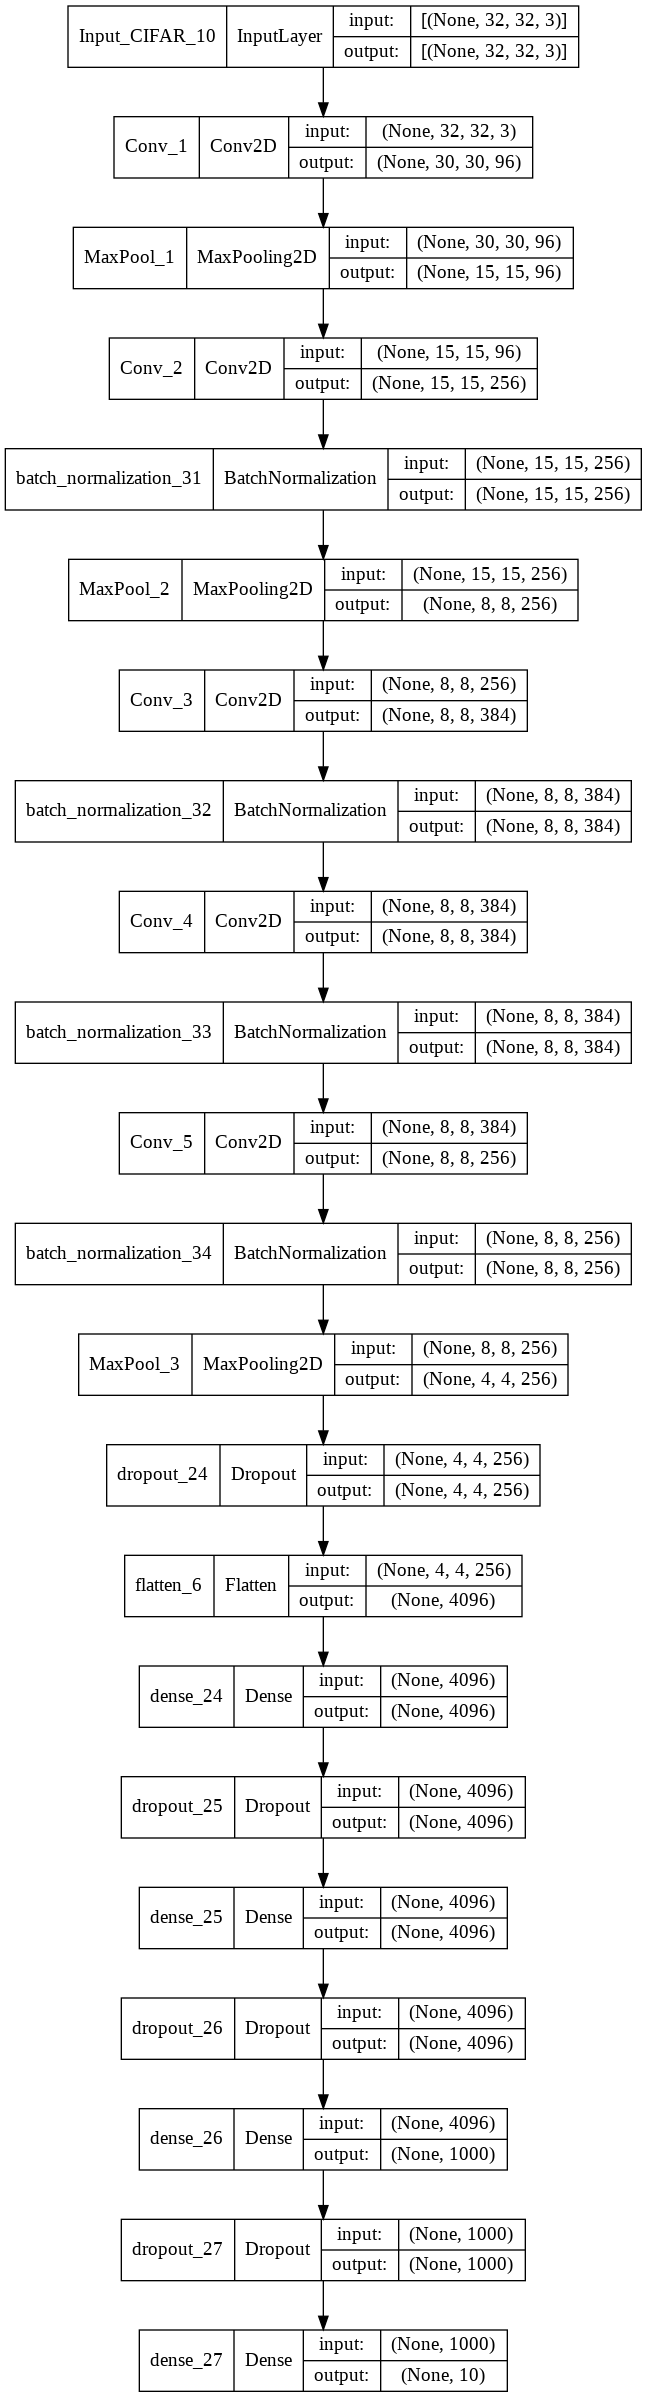

In [ ]:
# Final CNN network topology
inputs = keras.Input(shape = (32, 32, 3), name = 'Input_CIFAR_10')
x = layers.Conv2D(filters = 96, input_shape = (32, 32, 3), kernel_size = (3, 3), strides = (1, 1), kernel_regularizer = regularizers.l2(1e-4), padding = 'valid', name = 'Conv_1')(inputs)
X = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same', name = 'MaxPool_1')(x)
x = layers.Conv2D(filters = 256, input_shape = (32, 32, 3), kernel_size = (3, 3), strides = (1, 1), kernel_regularizer = regularizers.l2(1e-4), padding = 'same', name = 'Conv_2')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same', name = 'MaxPool_2')(x)
x = layers.Conv2D(filters = 384, input_shape = (32, 32, 3), activation = 'elu', kernel_size = (3, 3), strides = (1, 1), kernel_regularizer = regularizers.l2(1e-4), padding = 'same', name = 'Conv_3')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters = 384, input_shape = (32, 32, 3), activation = 'elu', kernel_size = (3, 3), strides = (1, 1), kernel_regularizer = regularizers.l2(1e-4), padding = 'same', name = 'Conv_4')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters = 256, input_shape = (32, 32, 3), activation = 'elu', kernel_size = (3, 3), strides = (1, 1), kernel_regularizer = regularizers.l2(1e-4), padding = 'same', name = 'Conv_5')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same', name = 'MaxPool_3')(x)
x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
x = layers.Dense(4096, activation = 'relu', kernel_initializer = initializers.GlorotNormal())(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(4096, activation = 'relu', kernel_initializer = initializers.GlorotNormal())(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1000, activation = 'relu', kernel_initializer = initializers.GlorotNormal())(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(10, activation = 'softmax')(x)
model = keras.Model(inputs = inputs, outputs = outputs, name = 'CIFAR_10_AlexNet_Model')
keras.utils.plot_model(model, show_shapes = True)